In [ ]:
pip install pandas numpy torch pyro-ppl scikit-learn matplotlib

C:\Users\darke\miniconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
C:\Users\darke\miniconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\darke\miniconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(


Normalized data sample:
            date_time      temp   rain_1h   snow_1h  clouds_all weather_main
0 2012-10-02 09:00:00  0.552013 -0.007464 -0.027231   -0.240240       Clouds
1 2012-10-02 10:00:00  0.636989 -0.007464 -0.027231    0.656899       Clouds
2 2012-10-02 11:00:00  0.654299 -0.007464 -0.027231    1.041387       Clouds
3 2012-10-02 12:00:00  0.697574 -0.007464 -0.027231    1.041387       Clouds
4 2012-10-02 13:00:00  0.777042 -0.007464 -0.027231    0.656899       Clouds

Discretized data sample:
            date_time  temp  rain_1h  snow_1h  clouds_all weather_main
0 2012-10-02 09:00:00   3.0      0.0      0.0         2.0       Clouds
1 2012-10-02 10:00:00   3.0      0.0      0.0         3.0       Clouds
2 2012-10-02 11:00:00   3.0      0.0      0.0         4.0       Clouds
3 2012-10-02 12:00:00   3.0      0.0      0.0         4.0       Clouds
4 2012-10-02 13:00:00   3.0      0.0      0.0         3.0       Clouds


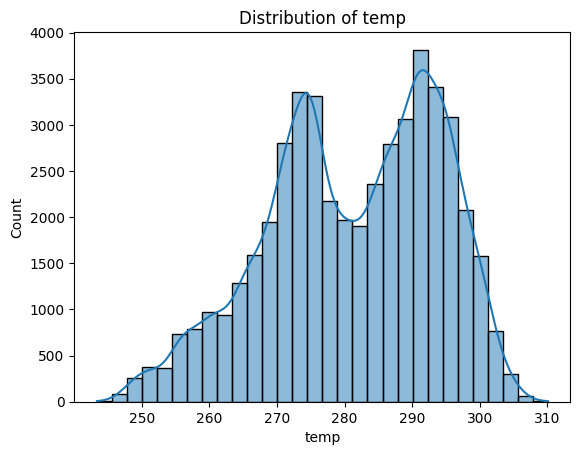

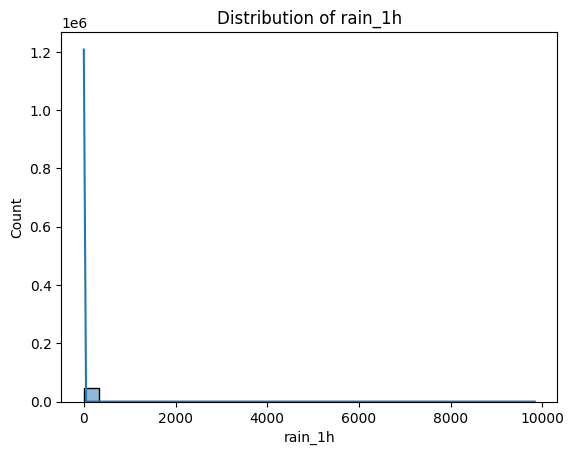

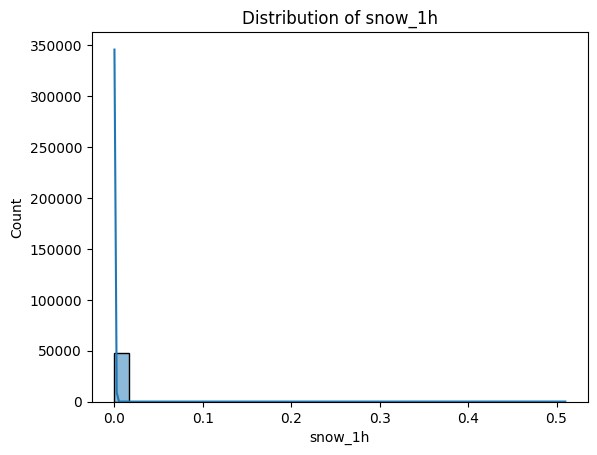

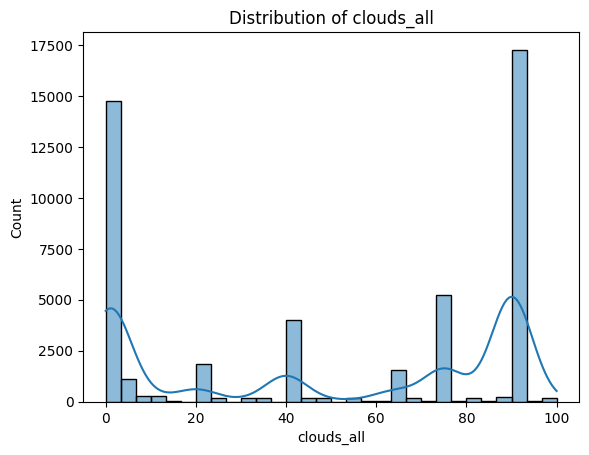

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

# load data set
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=['date_time'])

# Sort by datetime and filter features
df = df.sort_values('date_time')
weather_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
df = df[['date_time'] + weather_features + ['weather_main']].copy()

# Drop rows with missing or erroneous values
df = df.dropna()
df = df[df['temp'] > 200]  # Remove extreme outliers (temperature is in Kelvin)

# Option A: Normalize for Gaussian HMM
scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[weather_features] = scaler.fit_transform(df[weather_features])

# Option B: Discretize for Multinomial HMM
n_bins = 5
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
df_discrete = df.copy()
df_discrete[weather_features] = discretizer.fit_transform(df[weather_features])

# Plot histogram to visualize binning
for feature in weather_features:
    plt.figure()
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Count")

# View a preview of both preprocessed datasets
print("Normalized data sample:")
print(df_normalized.head())

print("\nDiscretized data sample:")
print(df_discrete.head())


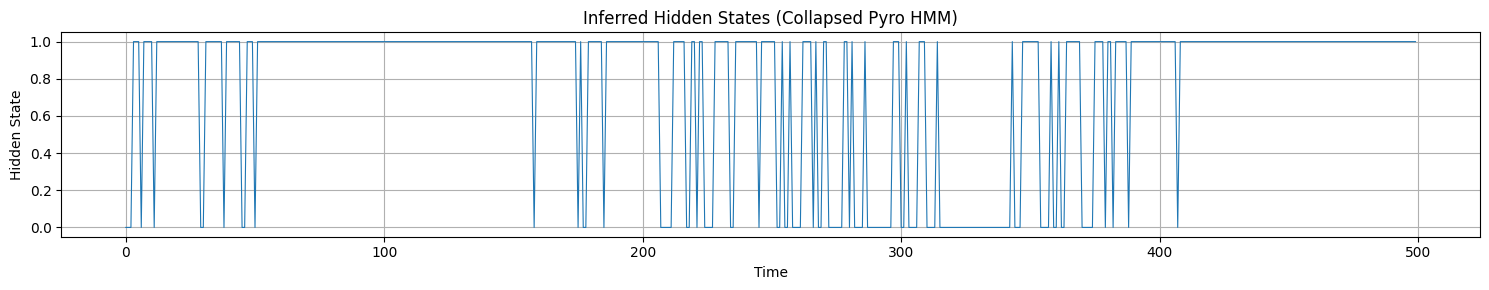

In [7]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import TraceEnum_ELBO, SVI
from pyro.optim import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pyro.clear_param_store()

# Load and preprocess data
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=["date_time"])
df = df[['date_time', 'temp', 'clouds_all']].dropna()
df = df[df['temp'] > 200]
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df = df.resample('D').mean().dropna()
df = df.iloc[:500]
data = torch.tensor(StandardScaler().fit_transform(df), dtype=torch.float)

# Parameters
num_states = 3
obs_dim = data.shape[1]
T = data.shape[0]

# Model
def model(data):
    with pyro.plate("states", num_states):
        locs = pyro.sample("locs", dist.Normal(0., 2.).expand([obs_dim]).to_event(1))
        scales = pyro.sample("scales", dist.LogNormal(0., 1.).expand([obs_dim]).to_event(1))
    trans_probs = pyro.sample("trans_probs", dist.Dirichlet(torch.ones(num_states)).expand([num_states]).to_event(1))
    init_probs = pyro.sample("init_probs", dist.Dirichlet(torch.ones(num_states)))
    
    log_probs = []
    probs = init_probs
    for t in range(T):
        probs = init_probs if t == 0 else probs @ trans_probs
        emission = dist.Normal(locs, scales).log_prob(data[t]).sum(-1)
        log_probs.append(torch.log(probs) + emission)
    return torch.stack(log_probs)

# Run (MAP decode, log prob)
log_probs = model(data)
hidden_states = log_probs.argmax(-1)

# Plot
plt.figure(figsize=(15, 3))
plt.plot(hidden_states.numpy(), lw=0.8)
plt.title("Inferred Hidden States (Collapsed Pyro HMM)")
plt.xlabel("Time")
plt.ylabel("Hidden State")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\darke\miniconda3\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'hidden_892', 'hidden_173', 'hidden_3090', 'hidden_3699', 'hidden_1290', 'hidden_3232', 'hidden_3676', 'hidden_1504', 'hidden_1749', 'hidden_1048', 'hidden_3546', 'hidden_4789', 'hidden_3914', 'hidden_1556', 'hidden_3884', 'hidden_4026', 'hidden_3802', 'hidden_778', 'hidden_3613', 'hidden_2592', 'hidden_1514', 'hidden_2024', 'hidden_4358', 'hidden_3619', 'hidden_1653', 'hidden_3717', 'hidden_4623', 'hidden_357', 'hidden_529', 'hidden_4350', 'hidden_2741', 'hidden_929', 'hidden_561', 'hidden_342', 'hidden_3896', 'hidden_1904', 'hidden_2941', 'hidden_1979', 'hidden_1381', 'hidden_931', 'hidden_1836', 'hidden_3496', 'hidden_3360', 'hidden_4682', 'hidden_3927', 'hidden_101', 'hidden_4217', 'hidden_4846', 'hidden_4064', 'hidden_2112', 'hidden_564', 'hidden_4117', 'hidden_3024', 'hidden_2588', 'hidden_4081', 'hidden_3588', 'hidden_4707', 'hidden_1679', 'hidden_3019', 'hidden_2976', 

[0] Loss = 45818.52
[50] Loss = 42062.33
[100] Loss = 36656.27
[150] Loss = 33974.27
[200] Loss = 31467.55
[250] Loss = 31472.28


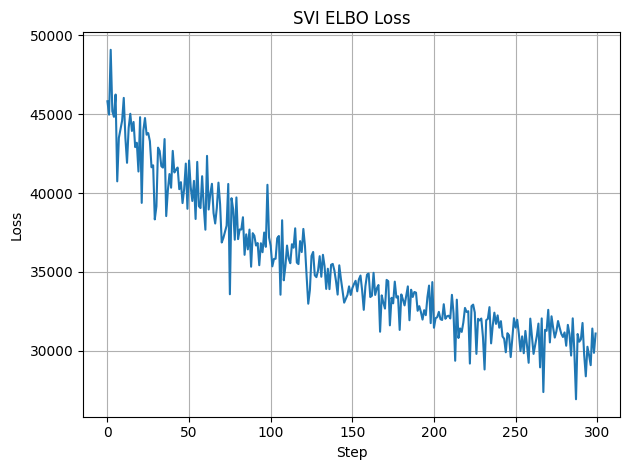

In [8]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pyro.clear_param_store()
pyro.set_rng_seed(0)

#  Load and normalize full dataset
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=["date_time"])
df = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']].dropna()
df = df[df['temp'] > 200]

# for tractability
df = df.iloc[:5000]  # <-- Remove or raise this if you want full dataset

# Normalize
scaler = StandardScaler()
data_np = scaler.fit_transform(df)
data = torch.tensor(data_np, dtype=torch.float)

#  Model parameters
T = data.shape[0]
obs_dim = data.shape[1]
num_states = 3

#  Pyro model 
def model(data):
    with pyro.plate("states", num_states):
        locs = pyro.sample("locs", dist.Normal(0., 2.).expand([obs_dim]).to_event(1))
        scales = pyro.sample("scales", dist.LogNormal(0., 1.).expand([obs_dim]).to_event(1))
    trans_probs = pyro.sample("trans_probs", dist.Dirichlet(torch.ones(num_states)).expand([num_states]).to_event(1))
    init_probs = pyro.sample("init_probs", dist.Dirichlet(torch.ones(num_states)))

    hidden = None
    for t in pyro.markov(range(T)):
        probs = init_probs if t == 0 else trans_probs[hidden]
        hidden = pyro.sample(f"hidden_{t}", dist.Categorical(probs))
        pyro.sample(f"obs_{t}", dist.Normal(locs[hidden], scales[hidden]).to_event(1), obs=data[t])

# Variational approximation
def guide(data):
    locs_loc = pyro.param("locs_loc", torch.randn(num_states, obs_dim))
    locs_scale = pyro.param("locs_scale", torch.ones(num_states, obs_dim), constraint=constraints.positive)
    scales_loc = pyro.param("scales_loc", torch.ones(num_states, obs_dim), constraint=constraints.positive)

    trans_alpha = pyro.param("trans_alpha", torch.ones(num_states, num_states), constraint=constraints.positive)
    init_alpha = pyro.param("init_alpha", torch.ones(num_states), constraint=constraints.positive)

    with pyro.plate("states", num_states):
        pyro.sample("locs", dist.Normal(locs_loc, locs_scale).to_event(1))
        pyro.sample("scales", dist.LogNormal(scales_loc, 0.1).to_event(1))

    pyro.sample("trans_probs", dist.Dirichlet(trans_alpha).to_event(1))
    pyro.sample("init_probs", dist.Dirichlet(init_alpha))

# Train using SVI 
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

losses = []
num_steps = 300  # Increase this as needed
for step in range(num_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 50 == 0:
        print(f"[{step}] Loss = {loss:.2f}")

# Plot ELBO loss curve 
plt.plot(losses)
plt.title("SVI ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess 
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", parse_dates=["date_time"])
df = df[['date_time', 'temp', 'clouds_all']].dropna()
df = df[df['temp'] > 200]
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df = df.resample('D').mean().dropna()
df = df.iloc[:500]
data = torch.tensor(StandardScaler().fit_transform(df), dtype=torch.float)

#  HMM parameters 
num_states = 3
obs_dim = data.shape[1]
T = data.shape[0]

# === Sample collapsed parameters (random, mock inference) ===
with pyro.plate("states", num_states):
    locs = torch.randn(num_states, obs_dim)
    scales = torch.exp(torch.randn(num_states, obs_dim))
trans_probs = torch.distributions.Dirichlet(torch.ones(num_states)).sample((num_states,))
init_probs = torch.distributions.Dirichlet(torch.ones(num_states)).sample()

# === Run forward + MAP decoding ===
log_probs = []
probs = init_probs
for t in range(T):
    probs = init_probs if t == 0 else probs @ trans_probs
    emission = dist.Normal(locs, scales).log_prob(data[t]).sum(-1)
    log_probs.append(torch.log(probs) + emission)
log_probs = torch.stack(log_probs)
hidden_states = log_probs.argmax(-1).numpy()

# === State summary ===
state_counts = np.bincount(hidden_states, minlength=num_states)
state_summary = pd.DataFrame({
    "State": np.arange(num_states),
    "Count": state_counts,
    "Proportion": state_counts / state_counts.sum()
})

# === Transition matrix ===
transitions = np.zeros((num_states, num_states), dtype=int)
for t in range(1, T):
    transitions[hidden_states[t-1], hidden_states[t]] += 1

transition_df = pd.DataFrame(transitions, columns=[f"To_{i}" for i in range(num_states)])
transition_df.insert(0, "From", [f"From_{i}" for i in range(num_states)])

# === Save to CSV if needed ===
state_summary.to_csv("state_summary.csv", index=False)
transition_df.to_csv("transition_matrix.csv", index=False)

# === Print summary tables ===
print("\nState Summary:\n", state_summary)
print("\nTransition Matrix:\n", transition_df)



State Summary:
    State  Count  Proportion
0      0    128       0.256
1      1    372       0.744
2      2      0       0.000

Transition Matrix:
      From  To_0  To_1  To_2
0  From_0    41    87     0
1  From_1    86   285     0
2  From_2     0     0     0
